In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\weiwei\AppData\Local\Temp\ipykernel_5780\3429415608.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

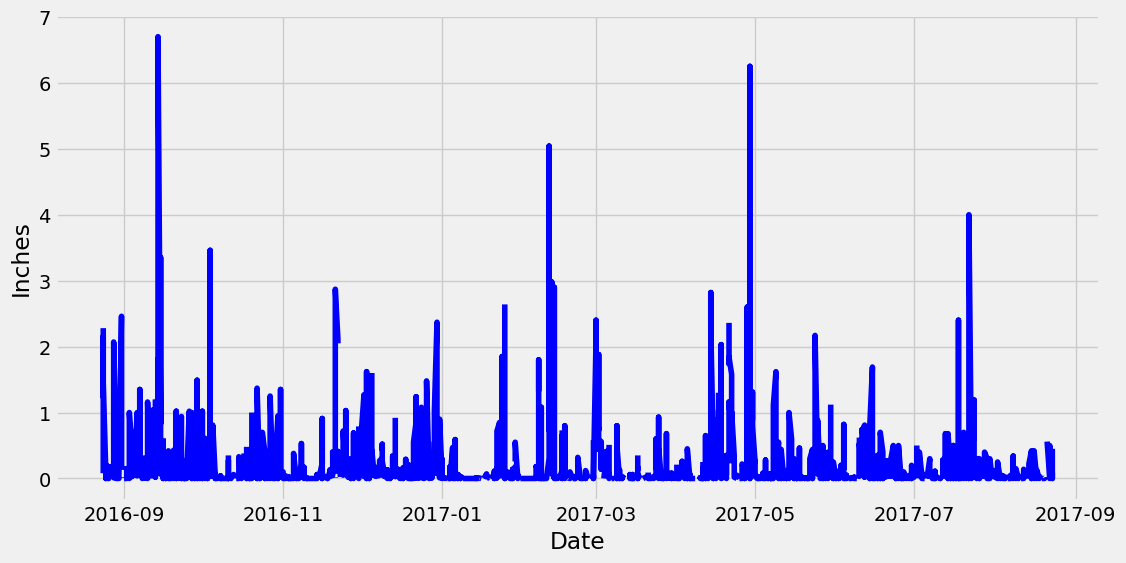

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

if isinstance(most_recent_date,str) :
    most_recent_date = dt.datetime.strptime(most_recent_date,'%Y-%m-%d')


# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.DataFrame(query,columns=['date','precipitation'])

# Sort the dataframe by date
precipitation_data['date'] = pd.to_datetime(precipitation_data['date'])
precipitation_data.sort_values('date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,6))
plt.plot(precipitation_data['date'],precipitation_data['precipitation'],color='b',linestyle='-')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_data['precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = (
    session.query(Measurement.station,func.count(Measurement.id).label('count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
).all()
active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations_query[0][0]
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == most_active_station_id)
).one()

print(most_active_station_id,temperature_stats.min_temp,temperature_stats.max_temp,temperature_stats.avg_temp)

USC00519281 54.0 85.0 71.66378066378067


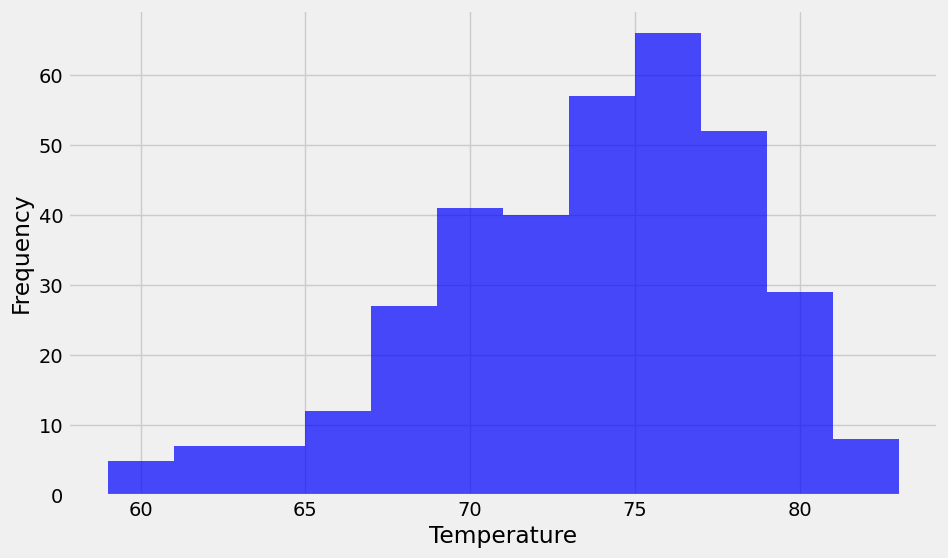

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
).all()

temperature_df = pd.DataFrame(temperature_data,columns=['tobs'])

plt.figure(figsize=(10,6))
plt.hist(temperature_df['tobs'],bins=12,color='blue',alpha=0.7)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [36]:
# Close Session
session.close()